<a href="https://colab.research.google.com/github/adib0073/TimeSeries-Using-TensorFlow/blob/main/Time_Series_Forecasting_with_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Forecasting with DNN using TensorFlow

In this notebook we will use a custom Deep Neural Network which can be used for forecasting Univariate Time Series data using TensorFlow. As an example of the time series data, we will be using the [Sunspot Data from Kaggle](https://www.kaggle.com/robervalt/sunspots). The data can be easily downloaded from my GitHub project [TimeSeries-Using-TensorFlow](https://github.com/adib0073/TimeSeries-Using-TensorFlow/blob/main/Data/Sunspots.csv). Now, let's begin! 

In [1]:
import tensorflow as tf

In [2]:
# Please validate the TF version and make sure it is above 2.0. Otherwise please download the latest TF version
print(tf.__version__)

2.4.0


### Import Modules

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
tf.random.set_seed(51)
np.random.seed(51)

### Downloading and loading the data

In [10]:
!wget --no-check-certificate https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv -O /tmp/sunspots.csv

--2020-12-23 05:21:20--  https://raw.githubusercontent.com/adib0073/TimeSeries-Using-TensorFlow/main/Data/Sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/plain]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.01s   

2020-12-23 05:21:21 (6.21 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [15]:
# Loading the data as a pandas dataframe
df = pd.read_csv('/tmp/sunspots.csv', index_col=0)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


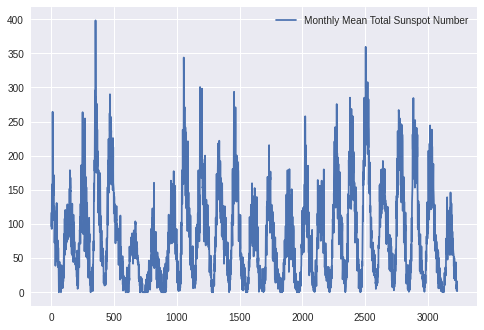

In [22]:
# Let's visualize the series
df.plot()
plt.show()

In [ ]:
# We don't see any clear trend, but we can see some seasonal patterns in the time series data

### Data Preparation

In [58]:
time_index = np.array(df['Date'])
data = np.array(df['Monthly Mean Total Sunspot Number'])
#time_index = time_index.reshape(-1,1)
#data = data.reshape(-1,1)

In [59]:
print(time_index.shape)
print(data.shape)

(3235,)
(3235,)


In [60]:
# Certain Hyper-parameters to tune
SPLIT_RATIO = 0.8
WINDOW_SIZE = 60
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

In [61]:
# Dividing into train-test split
split_index = int(SPLIT_RATIO * data.shape[0])
print(split_index)

2588


In [62]:
# Train-Test Split
train_data = data[:split_index]
train_time = time_index[:split_index]

test_data = data[split_index:]
test_time = time_index[split_index:]

In [63]:
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
  '''
  Utility function for time series data generation in batches
  '''
  ts_data = tf.data.Dataset.from_tensor_slices(data)
  ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
  ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
  ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  ts_data = ts_data.batch(batch_size).prefetch(1)
  return ts_data

In [64]:
train_dataset = ts_data_generator(train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
test_dataset = ts_data_generator(test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)


In [65]:
train_dataset

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

### TensorFlow DNN Model

In [67]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[WINDOW_SIZE], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(train_dataset, epochs=200,validation_data = test_dataset)

Epoch 1/200
79/79 [==============================] - 1s 9ms/step - loss: 2546.9874 - val_loss: 1215.2766
Epoch 2/200
79/79 [==============================] - 1s 7ms/step - loss: 1355.8905 - val_loss: 1010.8966
Epoch 3/200
79/79 [==============================] - 1s 7ms/step - loss: 1124.5238 - val_loss: 893.6034
Epoch 4/200
79/79 [==============================] - 1s 8ms/step - loss: 1071.7694 - val_loss: 810.0725
Epoch 5/200
79/79 [==============================] - 1s 8ms/step - loss: 932.4372 - val_loss: 767.9634
Epoch 6/200
79/79 [==============================] - 1s 6ms/step - loss: 876.1713 - val_loss: 740.3677
Epoch 7/200
79/79 [==============================] - 1s 8ms/step - loss: 950.3283 - val_loss: 706.0848
Epoch 8/200
79/79 [==============================] - 1s 7ms/step - loss: 849.1399 - val_loss: 675.4581
Epoch 9/200
79/79 [==============================] - 1s 7ms/step - loss: 796.9535 - val_loss: 664.1207
Epoch 10/200
79/79 [==============================] - 1s 6ms/step -

### Model Evaluation

In [71]:
time_int = np.array(list(range(len(data))))
time_int

array([   0,    1,    2, ..., 3232, 3233, 3234])

In [74]:
forecast=[]
for time in range(len(data) - WINDOW_SIZE):
  forecast.append(model.predict(data[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[split_index-WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]

In [86]:
# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, results).numpy()

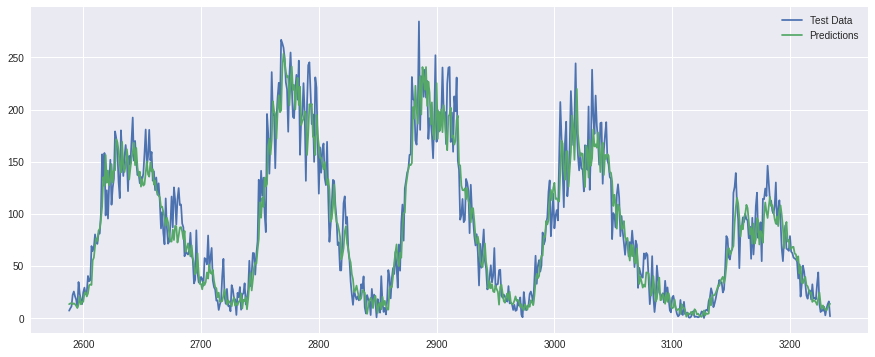

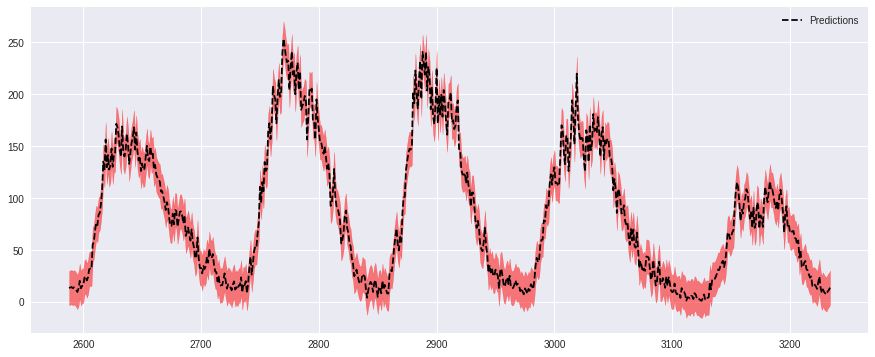

In [103]:
plt.figure(figsize=(15, 6))

plt.plot(list(range(split_index,len(data))), test_data, label = 'Test Data')
plt.plot(list(range(split_index,len(data))), results, label = 'Predictions')
#plt.fill_between(range(split_index,len(data)), results - error, results + error, alpha = 0.5, color = 'red')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
# Plotting with Confidence Intervals
#plt.plot(list(range(split_index,len(data))), test_data, label = 'Test Data')
plt.plot(list(range(split_index,len(data))), results, label = 'Predictions', color = 'k', linestyle = '--')
plt.fill_between(range(split_index,len(data)), results - error, results + error, alpha = 0.5, color = 'red')
plt.legend()
plt.show()

In [104]:
# Since forecast can never be accurate, it is always advisable to keep forecasts within confidence intervals or error bands